### Subset of 4000 random spectra

In [4]:
#------------------------------------------------------------------------------------
#IMPORT THE REQUIRED LIBRARIES
#------------------------------------------------------------------------------------
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import ensemble
from utils_gaia import heatmapconf_recall_prec, subset

import seaborn as sns
import matplotlib.pyplot as plt  
import timeit
import warnings

warnings.filterwarnings("ignore")

#Data loading
df= pd.read_csv("Spectrums_columns.csv")
df = df.drop(columns=['Unnamed: 0'])


#We standardize, average 0 standard deviation 1
scaler=StandardScaler()
fited=scaler.fit(df.iloc[:,6:66])
df.iloc[:,6:66]=scaler.transform(df.iloc[:,6:66])
scaler=StandardScaler()
fited=scaler.fit(df.iloc[:,66:])
df.iloc[:,66:]=scaler.transform(df.iloc[:,66:])

In [5]:
#subdf=subset(4000)
#subdf.to_csv("Subset_14_12_2020.csv")
subdf = pd.read_csv("Subset_14_12_2020.csv")
subdf = subdf.drop(columns=['Unnamed: 0'])

In [3]:
#Creation of the train and test dataset
X_sub = subdf.iloc[:,6:]
y_sub = subdf["feature"]

#Seed
seed = 4

#Train and test creation
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_sub, y_sub, test_size=0.2, random_state=seed)
#Label for the heatmap
label = list(np.unique(y_sub))

### Decision Tree

In [4]:
#-----------------------------------------
#DECISION TREE GRID SEARCH || SUBSET 4000
#-----------------------------------------
tic = timeit.default_timer()
#-------------------------------------------------------------------------------------------------------

grid_params={'max_depth': np.append(None, np.arange(1,10)),\
             'criterion': ['gini', 'entropy'],\
             'min_samples_split' : np.arange(5,256,25),\
             'max_features': ["sqrt","log2"]}
DT_GS= GridSearchCV(DecisionTreeClassifier(random_state= seed), grid_params, cv=4, n_jobs = -1, return_train_score=True)
DT_results=DT_GS.fit(X_train_sub, y_train_sub)


print("Best parameters DT: ", DT_results.best_params_)
print("Best cross-validation score DT: {:.3f}".format(DT_results.best_score_))

#-------------------------------------------------------------------------------------------------------
toc = timeit.default_timer()
TimeDT = toc -tic
print ("Computation time = " + str((toc - tic)) + "s") 

Best parameters DT:  {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 55}
Best cross-validation score DT: 0.351
Computation time = 9.497433800000001s


In [5]:
#Model training
DT_sub = DecisionTreeClassifier(criterion = 'gini', max_depth = None, max_features= 'sqrt',\
                                min_samples_split= 55,  random_state = seed)
DT_sub.fit(X_train_sub, y_train_sub)

DecisionTreeClassifier(max_features='sqrt', min_samples_split=55,
                       random_state=4)

In [6]:
#5-fold cross validation
kf = KFold(n_splits=5)
crossDT_sub = cross_val_score(DT_sub, X_train_sub, y_train_sub, cv=kf, scoring= "accuracy")
print('The cross-validation values for 5 sets are', crossDT_sub)
print('The cross validation average on the 5 sets is {0:.3f}'.format(np.mean(crossDT_sub)))

#Accuracy
print("Accuracy:", accuracy_score(y_test_sub, DT_sub.predict(X_test_sub)))

The cross-validation values for 5 sets are [0.3234375 0.3421875 0.3328125 0.3203125 0.3578125]
The cross validation average on the 5 sets is 0.335
Accuracy: 0.3275


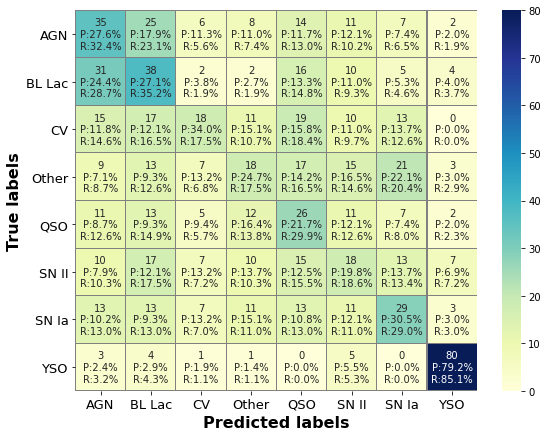

In [7]:
cma = confusion_matrix(y_test_sub, DT_sub.predict(X_test_sub))
heatmapconf_recall_prec(cma, label)

### Support Vector Machine

In [4]:
#-----------------------------------------
#SVC GRID SEARCH || SUBSET 4000
#-----------------------------------------
tic = timeit.default_timer()
#-------------------------------------------------------------------------------------------------------

grid_params={'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], \
             'C': [0.01, 0.1,1,10,50,100],\
             'gamma': [0.001, 0.01, 0.1, 1, 10]}
SVC_GS= GridSearchCV(SVC(random_state= seed), grid_params, cv=4, n_jobs = -1, return_train_score=True)
SVC_results=SVC_GS.fit(X_train_sub, y_train_sub)


print("Best parameters: ", SVC_results.best_params_)
print("Best cross-validation score: {:.3f}".format(SVC_results.best_score_))

#-------------------------------------------------------------------------------------------------------
toc = timeit.default_timer()
TimeSVC = tic - toc
print ("Computation time = " + str((toc - tic)) + "s") 

Best parameters:  {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
Best cross-validation score: 0.408
Computation time = 208.65864189999957s


In [8]:
#Model training
SVC_sub = SVC(C = 100, gamma = 0.1, kernel = 'rbf',  random_state = seed)
SVC_sub.fit(X_train_sub, y_train_sub)

SVC(C=100, gamma=0.1, random_state=4)

In [9]:
#5-fold cross validation
kf = KFold(n_splits=5)
crossSVC_sub = cross_val_score(SVC_sub, X_train_sub, y_train_sub, cv=kf, scoring= "accuracy")

print('The cross-validation values for 5 sets are', crossSVC_sub)
print('The cross validation average on the 5 sets is {0:.3f}'.format(np.mean(crossSVC_sub)))

#Accuracy
print("Accuracy:", accuracy_score(y_test_sub, SVC_sub.predict(X_test_sub)))

The cross-validation values for 5 sets are [0.371875  0.425     0.4046875 0.4140625 0.4      ]
The cross validation average on the 5 sets is 0.403
Accuracy: 0.4


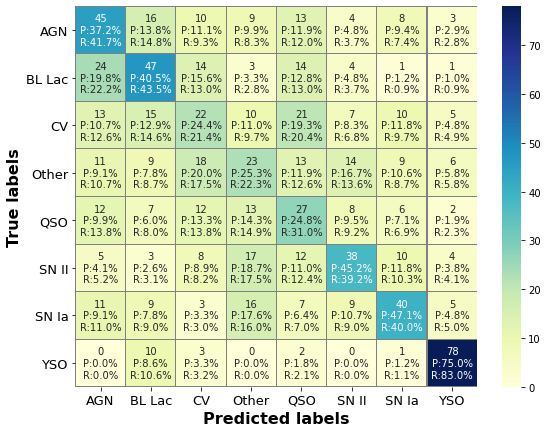

In [10]:
#Confusion Matrix
cma = confusion_matrix(y_test_sub, SVC_sub.predict(X_test_sub))
heatmapconf_recall_prec(cma, label)

### Random Forest

In [28]:
#At this point we are going to apply a random forest over the new subset

#-----------------------------------------
#RF GRID SEARCH || SUBSET 4000
#-----------------------------------------
tic = timeit.default_timer()
#-------------------------------------------------------------------------------------------------------

grid_params={'max_depth': np.append(None, np.arange(1,10)), \
             'n_estimators': [10, 50, 100, 150, 200, 250, 300, 350, 400], \
             'criterion': ['gini', 'entropy'], \
             'max_features': ["sqrt","log2"]}
RF_GS= GridSearchCV(RandomForestClassifier(random_state= seed), grid_params, cv=4, n_jobs = -1, return_train_score=True)
RF_results=RF_GS.fit(X_train_sub, y_train_sub)


print("Best parameters: ", RF_results.best_params_)
print("Best cross-validation score: {:.3f}".format(RF_results.best_score_))

#-------------------------------------------------------------------------------------------------------
toc = timeit.default_timer()
TimeRF = toc - tic
print ("Computation time = " + str((toc - tic)) + "s") 


Best parameters:  {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 400}
Best cross-validation score: 0.515
Computation time = 633.9211862999999s


In [11]:
#Model training
RF_sub = RandomForestClassifier(max_depth= None, n_estimators = 400, criterion = 'gini',\
                                max_features =  'sqrt', random_state = seed, n_jobs = -1)
RF_sub.fit(X_train_sub, y_train_sub)

RandomForestClassifier(max_features='sqrt', n_estimators=400, n_jobs=-1,
                       random_state=4)

In [13]:
#5-fold cross validation
kf = KFold(n_splits=5)
crossRF_sub = cross_val_score(RF_sub, X_train_sub, y_train_sub, cv=kf, scoring= "accuracy")

print('The cross-validation values for 5 sets are', crossRF_sub)
print('The cross validation average on the 5 sets is {0:.3f}'.format(np.mean(crossRF_sub)))


#Accuracy
print("Accuracy:", accuracy_score(y_test_sub, RF_sub.predict(X_test_sub)))

The cross-validation values for 5 sets are [0.509375  0.5359375 0.5359375 0.496875  0.5046875]
The cross validation average on the 5 sets is 0.517
Accuracy: 0.535


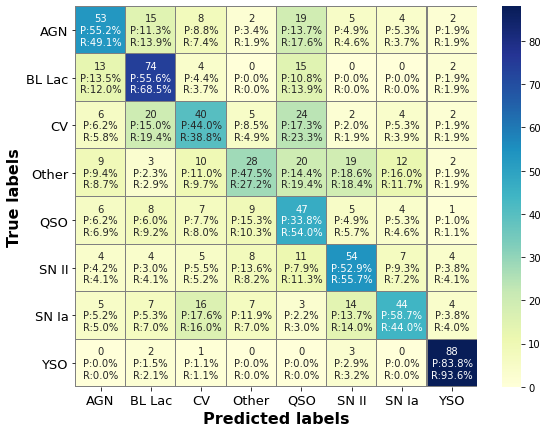

In [14]:
#Confusion Matrix
cma = confusion_matrix(y_test_sub, RF_sub.predict(X_test_sub))
heatmapconf_recall_prec(cma, label)

### Gradient Boosting Classifier

In [30]:
#-----------------------------------------
#GBC GRID SEARCH || SUBSET 4000
#-----------------------------------------
tic = timeit.default_timer()
#-------------------------------------------------------------------------------------------------------

grid_params={'max_depth':  np.append(None, np.arange(1,10)), \
             'n_estimators': [10, 25, 50, 100, 200],\
             'learning_rate': [0.01, 0.1, 1]}

GBC_GS= GridSearchCV(ensemble.GradientBoostingClassifier(random_state= seed), grid_params, cv=4, n_jobs = -1, return_train_score=True)
GBC_results=GBC_GS.fit(X_train_sub, y_train_sub)


print("Best parameters: ", GBC_results.best_params_)
print("Best cross-validation score: {:.3f}".format(GBC_results.best_score_))

#-------------------------------------------------------------------------------------------------------
toc = timeit.default_timer()
TimeGBC = toc - tic
print ("Computation time = " + str((toc - tic)) + "s") 

Best parameters:  {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
Best cross-validation score: 0.470
Computation time = 9461.4298732s


In [15]:
#Model training
GBC_sub = ensemble.GradientBoostingClassifier(learning_rate = 0.1, max_depth = 7, n_estimators = 200, random_state = seed)
GBC_sub.fit(X_train_sub, y_train_sub)

GradientBoostingClassifier(max_depth=7, n_estimators=200, random_state=4)

In [16]:
#5-fold cross validation
kf = KFold(n_splits=5)
crossGBC_sub = cross_val_score(GBC_sub, X_train_sub, y_train_sub, cv=kf, scoring= "accuracy")

print('The cross-validation values for 5 sets are', crossGBC_sub)
print('The cross validation average on the 5 sets is {0:.3f}'.format(np.mean(crossGBC_sub)))


#Accuracy
print("Accuracy:", accuracy_score(y_test_sub, GBC_sub.predict(X_test_sub)))

The cross-validation values for 5 sets are [0.4796875 0.48125   0.4828125 0.4609375 0.4546875]
The cross validation average on the 5 sets is 0.472
Accuracy: 0.48875


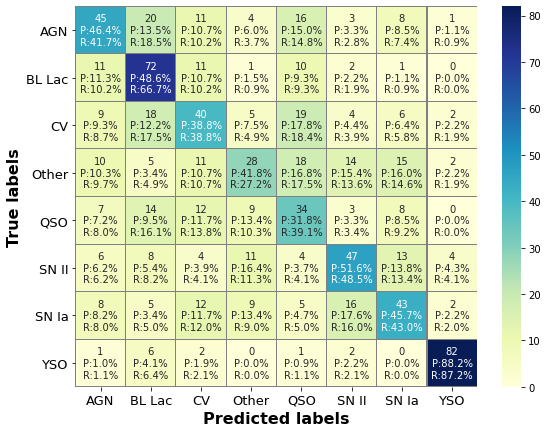

In [17]:
#Confusion Matrix
cma = confusion_matrix(y_test_sub, GBC_sub.predict(X_test_sub))
heatmapconf_recall_prec(cma, label)

In [41]:
def metrics(Xtest, ytest, av, decimal, names, models):
    subset_metrics  = pd.DataFrame()

    for i, model in enumerate(models):
        metrics = {'Model': names[i],
                   'Precision': round(precision_score(ytest, model.predict(Xtest), average = av), decimal),
                   'Recall': round(recall_score(ytest, model.predict(Xtest), average = av), decimal),
                   'F1 score': round(f1_score(ytest, model.predict(Xtest), average = av), decimal),
                   'Accuracy': round(accuracy_score(ytest, model.predict(Xtest)), decimal)}
        df_mod = pd.DataFrame(metrics, index=[i])
        subset_metrics = pd.concat([subset_metrics , df_mod])
    return subset_metrics

In [43]:
nam = ['DT', 'SVM', 'RF', 'GBC']
mod = [DT_sub, SVC_sub, RF_sub, GBC_sub]

metrics(X_test_sub, y_test_sub, 'macro', 3, nam, mod)

,Model,Precision,Recall,F1 score,Accuracy
0,DT,0.331,0.331,0.325,0.328
1,SVM,0.399,0.403,0.399,0.400
2,RF,0.539,0.539,0.530,0.535
3,GBC,0.491,0.490,0.486,0.489
